In [1]:
import dv_processing as dv
import torch
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.model_loader_refac import ModelLoader
from snn_delays.utils.train_utils_refact_minimal import get_device
from snn_delays.utils.hw_aware_utils import quantize_weights
from snn_delays.utils.hw_aware_utils import save_weights_delays, save_state
import numpy as np
import os
device = get_device() 

# For reproducibility
torch.manual_seed(10)

# 25Hz
# ckpt_dir = 'abcxo' # 250, 1e6
# model = 'abcxo_f_9233333333333333' #45x45

# ckpt_dir = 'abcxo_32' # 250, 1e6
# model = 'abcxo_f_9916666666666667' #32x32

# ckpt_dir = 'abcxo_32_24' # 250, 1e6
# model = 'abcxo_f_9783333333333333'

# ckpt_dir = 'abcxo_32_24_1ms' # 250, 1e6
# model = 'abcxo_f_9916666666666667_1ms'

# ckpt_dir = 'abcxo_32_24_1ms_crop128_32' # 250, 1e6
# model = 'abcxo_f_980'

# #15Hz
# ckpt_dir = 'abcxo_32_24_1ms_15Hz' # 250, 1e6
# model = 'abcxo_d10_binary_9866666666666667'


### loihi data
# ckpt_dir = 'abcxo_32_24_15Hz_Loihi' # 250, 1e6
# model = 'abcxo_f_9949152542372882'

# ckpt_dir = 'abcxo_64_96_1ms_15Hz' # 250, 1e6
# model = 'abcxo_f_9711538461538461_max_20epoch' 

## convolutional
# ckpt_dir = 'abcxo_32_Conv_15Hz' # 250, 1e6
# model = 'abcxo_conv_32_15Hz_5channel_9711864406779661_max_10epoch'

# ckpt_dir = 'abcxo_32_Conv_15Hz' # 100ms 
# model = 'abcxo_conv_32_15Hz_5channel_v3_9610169491525424_max_10epoch'

ckpt_dir = 'abcxo_64_Conv_15Hz' # 100ms 
model = 'abcxo_conv_64_15Hz_shallow_binary_978021978021978_max_9epoch'

Running on: cuda:0


In [2]:
# dataset = 'davis'
# #total_time = 50
# total_time = 250
# batch_size = 64
# folder_name = 'ABCXO_15Hz'
# size = 32 # or 45

# # DATASET
# DL = DatasetLoader(dataset=dataset,
#                   caching='memory',
#                   num_workers=0,
#                   batch_size=batch_size,
#                   total_time=total_time,
#                   sensor_size_to = size,
#                   folder_name = folder_name)
# train_loader, test_loader, dataset_dict = DL.get_dataloaders()

dataset = 'davis_loihi'

#size = 32
size = 64

if size == 32:
    total_time = 250
    batch_size = 64
    folder_name = 'FromLoihi_ABCXO'
elif size == 64:
    total_time = 100
    batch_size = 64
    folder_name = 'FromLoihi_ABCXO_15Hz_64_robust'

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to=size,
                  folder_name = folder_name)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()


snn = ModelLoader(model, ckpt_dir, batch_size, device) 

[Downsample(time_factor=1, spatial_factor=1.0, sensor_size=None, target_size=None), ToFrame(sensor_size=(64, 64, 2), time_window=None, event_count=None, n_time_bins=100, n_event_bins=None, overlap=0, include_incomplete=False)]
Delta t: 1.0 ms
Instance of <class 'snn_delays.snn_refactored.SNN'> loaded successfully


In [3]:
#snn.input2spike_th = 0.5
_, __ = snn.test(test_loader)

1456
Test Loss: 0.03677817223512608
Avg spk_count per neuron for all 100 time-steps 8442.207188644688
Test Accuracy of the model on the test samples: 97.665



In [4]:
weight_params_names = [name for name, param in snn.named_parameters() if 'linear' in name or 'conv' in name]

In [5]:
weight_params_names

['layers.0.conv.weight', 'layers.2.linear.weight', 'layers.3.linear.weight']

In [6]:
def getattr_dotted(obj, attr_str):
    for attr in attr_str.split('.'):
        obj = getattr(obj, attr)
    return obj
print(getattr_dotted(snn, weight_params_names[0]))
print(getattr_dotted(snn, weight_params_names[0]).shape)

Parameter containing:
tensor([[[[ 0.1076,  0.0517,  0.2315,  0.1801],
          [ 0.2869,  0.1001,  0.1759,  0.0948],
          [ 0.1373,  0.2473,  0.1520,  0.2378],
          [ 0.2246,  0.0374,  0.2602,  0.2234]],

         [[ 0.1781,  0.2644,  0.0965,  0.1615],
          [ 0.0952,  0.2588,  0.3385,  0.2303],
          [ 0.1682,  0.3385,  0.1924,  0.3261],
          [ 0.3405,  0.2574,  0.0934,  0.3451]]],


        [[[ 0.1940,  0.2056,  0.3294,  0.1074],
          [ 0.2594,  0.0361,  0.3113,  0.2441],
          [-0.0180,  0.0789,  0.0909,  0.0754],
          [ 0.0593,  0.0045,  0.0807,  0.0076]],

         [[ 0.0908,  0.1971,  0.2517,  0.2209],
          [ 0.2011,  0.1276,  0.2219,  0.0271],
          [ 0.1101,  0.2449,  0.1618,  0.1575],
          [-0.0122, -0.0015,  0.2380,  0.1871]]],


        [[[ 0.2194,  0.3296,  0.2749,  0.2789],
          [ 0.0881,  0.1245,  0.0714,  0.1787],
          [ 0.1992,  0.3380,  0.2431,  0.2533],
          [ 0.1141,  0.0566,  0.0788,  0.1993]],

    

### Weight quantization

In [7]:
quant_bits = 8

quantize_weights(snn, quant_bits, last_layer=True, symmetry=True, print_info=True)
_, __ = snn.test(test_loader)

add_name = '_q'+str(quant_bits)

----layers.0.conv.weight----
n_unique before quantization: 256, 225 pos 31 neg


max_value before quantization: 0.3613075613975525
n_unique after quantization: 131, 104 pos 27 neg
max_value after quantization: 0.35848483443260193, delta_w: 0.002822715323418379
----layers.2.linear.weight----
n_unique before quantization: 196368, 95793 pos 100575 neg
max_value before quantization: 0.1715363711118698
n_unique after quantization: 197, 83 pos 113 neg
max_value after quantization: 0.17019625008106232, delta_w: 0.001340127899311483
----layers.3.linear.weight----
n_unique before quantization: 480, 235 pos 245 neg
max_value before quantization: 0.5780142545700073
n_unique after quantization: 154, 61 pos 92 neg
max_value after quantization: 0.573498547077179, delta_w: 0.004515736363828182
1456
Test Loss: 0.041355024699283684
Avg spk_count per neuron for all 100 time-steps 8401.236263736264
Test Accuracy of the model on the test samples: 96.772



<AxesSubplot:>

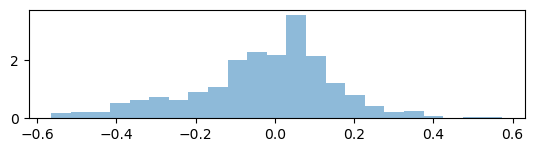

In [8]:
import matplotlib.pyplot as plt
from snn_delays.utils.visualization_utils import plot_param
plt.subplot(311)
#plot_param(snn.layers[0].linear, 'histogram_nonzero')
plot_param(snn.layers[-1].linear, 'histogram_nonzero')
# plt.subplot(312)
# plot_param(snn.f1_o, 'histogram_nonzero')
# plt.subplot(313)
# plot_param(snn.f2_o, 'histogram_nonzero')

### Save weights, delays, spikes and mems

In [9]:
ckpt_dir_2 = 'weights_' + model + add_name
save_path = os.path.join(
    os.environ.get('SNN_CHECKPOINTS_PATH'), ckpt_dir, ckpt_dir_2)

save_weights_delays(snn, path=save_path)

Weights and delays saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\abcxo_64_Conv_15Hz\weights_abcxo_conv_64_15Hz_shallow_binary_978021978021978_max_9epoch_q8
